In [10]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np

import torch
import tensorflow as tf
import os
import zipfile
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import fcluster

from umap import UMAP
from sklearn.cluster import DBSCAN

from textblob import TextBlob



In [12]:
# Check RAM
!cat /proc/meminfo | grep Mem


torch.cuda.empty_cache()  # clears unused GPU memory

tf.keras.backend.clear_session()



MemTotal:       32873392 kB
MemFree:        22020444 kB
MemAvailable:   30400412 kB


In [13]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow GPU warnings

# os.makedirs("/root/.kaggle", exist_ok=True)
# !mv kaggle.json /root/.kaggle/

# !chmod 600 /root/.kaggle/kaggle.json


In [14]:
# !kaggle datasets download -d olistbr/brazilian-ecommerce

In [15]:
# with zipfile.ZipFile("brazilian-ecommerce.zip", "r") as zip_ref:
#     zip_ref.extractall("brazilian-ecommerce")

In [16]:

base_path = "/kaggle/input/brazilian-ecommerce/"

file_paths = {
    "customers": base_path + "olist_customers_dataset.csv",
    "geolocation": base_path + "olist_geolocation_dataset.csv",
    "order_items": base_path + "olist_order_items_dataset.csv",
    "order_payments": base_path + "olist_order_payments_dataset.csv",
    "order_reviews": base_path + "olist_order_reviews_dataset.csv",
    "orders": base_path + "olist_orders_dataset.csv",
    "products": base_path + "olist_products_dataset.csv",
    "sellers": base_path + "olist_sellers_dataset.csv",
    "category_translation": base_path + "product_category_name_translation.csv"
}

dataframes = {}
for key, filename in file_paths.items():
    dataframes[key] = pd.read_csv(os.path.join("", filename))

preview_data = {key: df.head() for key, df in dataframes.items()}
preview_data.keys()

dict_keys(['customers', 'geolocation', 'order_items', 'order_payments', 'order_reviews', 'orders', 'products', 'sellers', 'category_translation'])

In [17]:
# !pip install ace_tools

In [18]:
preview_data = {key: df.head() for key, df in dataframes.items()}
preview_data

{'customers':                         customer_id                customer_unique_id  \
 0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
 1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
 2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
 3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
 4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
 
    customer_zip_code_prefix          customer_city customer_state  
 0                     14409                 franca             SP  
 1                      9790  sao bernardo do campo             SP  
 2                      1151              sao paulo             SP  
 3                      8775        mogi das cruzes             SP  
 4                     13056               campinas             SP  ,
 'geolocation':    geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
 0                         1037       -23.

In [19]:
dataframes["orders"]["order_purchase_timestamp"] = pd.to_datetime(dataframes["orders"]["order_purchase_timestamp"])

for name, df in dataframes.items():
    print(f"{name}: {df.isnull().sum().sum()} missing values")

dataframes["order_reviews"].dropna(subset=["review_score"], inplace=True)
dataframes["order_items"].dropna(subset=["product_id"], inplace=True)


customers: 0 missing values
geolocation: 0 missing values
order_items: 0 missing values
order_payments: 0 missing values
order_reviews: 145903 missing values
orders: 4908 missing values
products: 2448 missing values
sellers: 0 missing values
category_translation: 0 missing values


In [20]:
dataframes["order_reviews"] = dataframes["order_reviews"].dropna(subset=["review_score"])

dataframes["orders"] = dataframes["orders"].dropna(subset=["customer_id", "order_purchase_timestamp"])

dataframes["products"] = dataframes["products"].dropna(subset=["product_category_name"])

In [21]:
orders_customers = pd.merge(dataframes["orders"], dataframes["customers"], on="customer_id", how="inner")

orders_payments = pd.merge(orders_customers, dataframes["order_payments"], on="order_id", how="left")

order_items_products = pd.merge(dataframes["order_items"], dataframes["products"], on="product_id", how="left")
orders_full = pd.merge(orders_payments, order_items_products, on="order_id", how="left")

orders_full_reviews = pd.merge(orders_full, dataframes["order_reviews"], on="order_id", how="left")

orders_full_reviews = pd.merge(orders_full_reviews, dataframes["category_translation"], on="product_category_name", how="left")

orders_full_reviews["order_purchase_timestamp"] = pd.to_datetime(orders_full_reviews["order_purchase_timestamp"])
latest_date = orders_full_reviews["order_purchase_timestamp"].max()

customer_group = orders_full_reviews.groupby("customer_unique_id").agg({
    "order_purchase_timestamp": "max",
    "order_id": "nunique",
    "payment_value": "sum",
    "product_category_name": "nunique",
    "review_score": "mean",
    "customer_city": "first",
    "customer_state": "first",
}).reset_index()

customer_group["recency_days"] = (latest_date - customer_group["order_purchase_timestamp"]).dt.days

customer_group.rename(columns={
    "order_id": "order_count",
    "payment_value": "total_payment",
    "product_category_name": "unique_categories",
    "review_score": "avg_review_score"
}, inplace=True)

customer_group = customer_group[[
    "customer_unique_id", "customer_city", "customer_state",
    "order_purchase_timestamp", "recency_days", "order_count",
    "total_payment", "unique_categories", "avg_review_score"
]]

customer_group.head()


customer_unique_id customer_city customer_state  \
0  0000366f3b9a7992bf8c76cfdf3221e2       cajamar             SP   
1  0000b849f77a49e4a4ce2b2a4ca5be3f        osasco             SP   
2  0000f46a3911fa3c0805444483337064      sao jose             SC   
3  0000f6ccb0745a6a4b88665a16c9f078         belem             PA   
4  0004aac84e0df4da2b147fca70cf8255      sorocaba             SP   

  order_purchase_timestamp  recency_days  order_count  total_payment  \
0      2018-05-10 10:56:27           160            1         141.90   
1      2018-05-07 11:11:27           163            1          27.19   
2      2017-03-10 21:05:03           585            1          86.22   
3      2017-10-12 20:29:41           369            1          43.62   
4      2017-11-14 19:45:42           336            1         196.89   

   unique_categories  avg_review_score  
0                  1               5.0  
1                  1               4.0  
2                  1               3.0  
3                  1               4.0  
4                  1               5.0

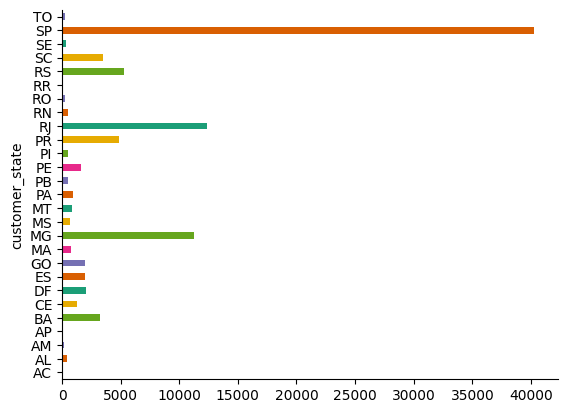

In [22]:
customer_group.groupby('customer_state').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [23]:
# Numerical features for clustering
features = customer_group[[
    "recency_days", "order_count", "total_payment",
    "unique_categories", "avg_review_score"
]]

In [24]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)


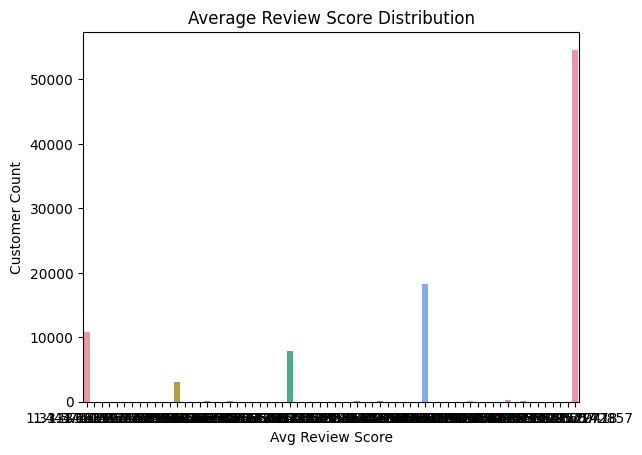

In [25]:
sns.countplot(x="avg_review_score", data=customer_group)
plt.title("Average Review Score Distribution")
plt.xlabel("Avg Review Score")
plt.ylabel("Customer Count")
plt.show()


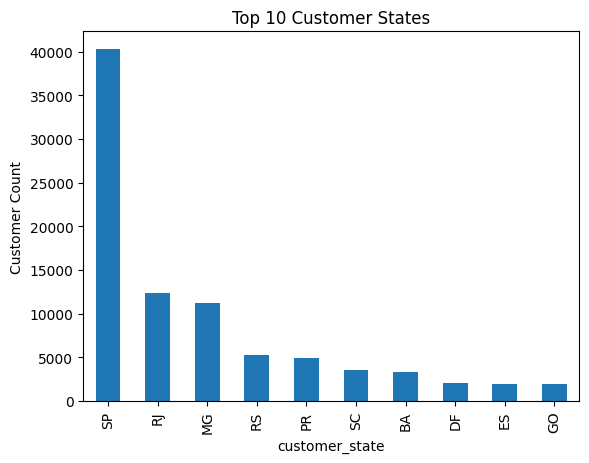

In [26]:
top_states = customer_group["customer_state"].value_counts().head(10)
top_states.plot(kind="bar", title="Top 10 Customer States")
plt.ylabel("Customer Count")
plt.show()

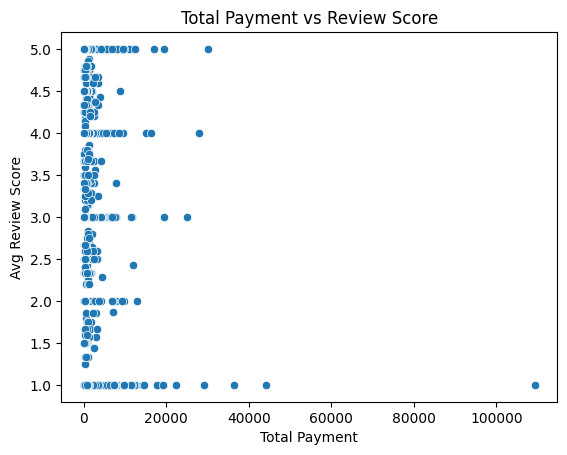

In [27]:
sns.scatterplot(data=customer_group, x="total_payment", y="avg_review_score")
plt.title("Total Payment vs Review Score")
plt.xlabel("Total Payment")
plt.ylabel("Avg Review Score")
plt.show()

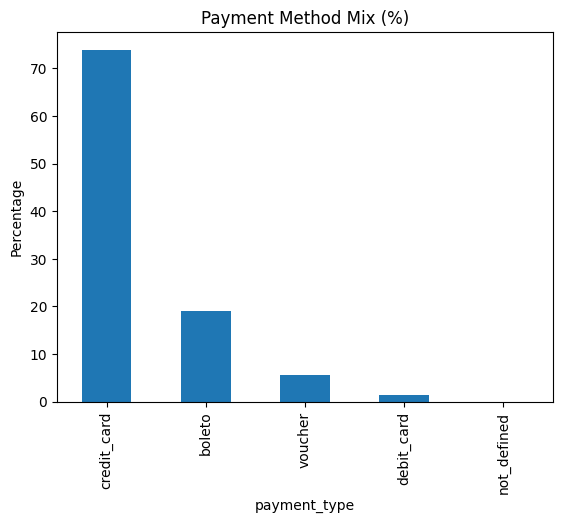

In [28]:
payment_mix = dataframes["order_payments"]["payment_type"].value_counts(normalize=True) * 100
payment_mix.plot(kind='bar', title='Payment Method Mix (%)')
plt.ylabel("Percentage")
plt.show()


In [29]:
customer_group["log_total_payment"] = np.log1p(customer_group["total_payment"])

In [30]:
customer_group['order_count'] = customer_group['order_count'].replace([np.inf, -np.inf], np.nan)

customer_group = customer_group.dropna(subset=['order_count'])

customer_group['log_total_payment'] = customer_group['log_total_payment'].replace([np.inf, -np.inf], np.nan)

customer_group = customer_group.dropna(subset=['log_total_payment'])

customer_group['recency_days'] = customer_group['recency_days'].replace([np.inf, -np.inf], np.nan)

customer_group = customer_group.dropna(subset=['recency_days'])

customer_group['avg_review_score'] = customer_group['avg_review_score'].replace([np.inf, -np.inf], np.nan)

customer_group = customer_group.dropna(subset=['avg_review_score'])


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


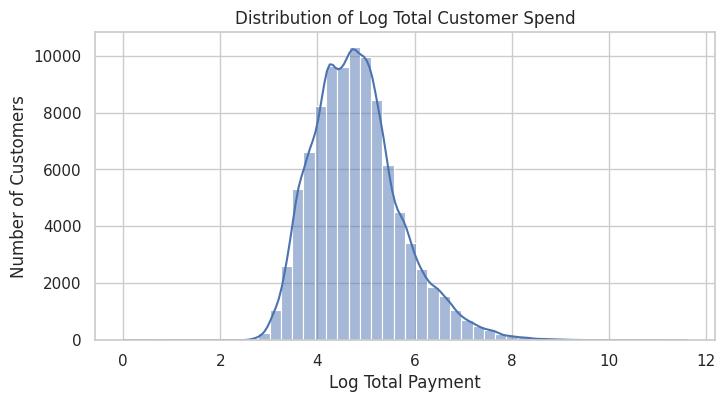

In [31]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.histplot(customer_group['log_total_payment'], bins=50, kde=True)
plt.title('Distribution of Log Total Customer Spend')
plt.xlabel('Log Total Payment')
plt.ylabel('Number of Customers')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


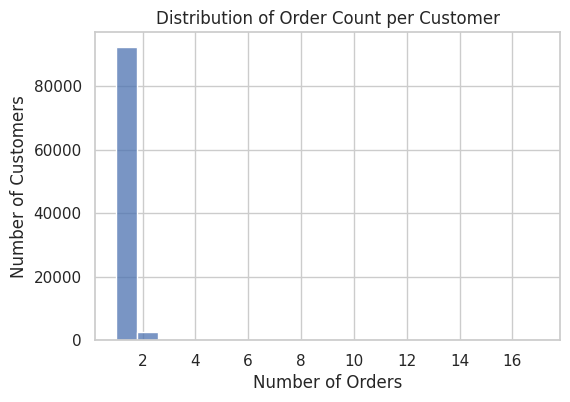

In [32]:
plt.figure(figsize=(6, 4))
sns.histplot(customer_group['order_count'], bins=20, kde=False)
plt.title('Distribution of Order Count per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


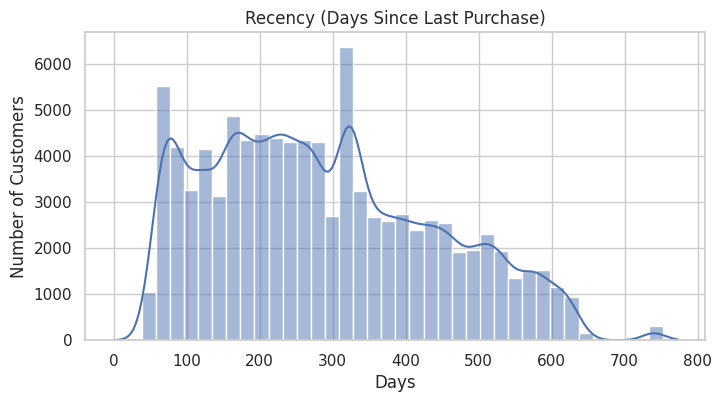

In [33]:
plt.figure(figsize=(8, 4))
sns.histplot(customer_group['recency_days'], bins=40, kde=True)
plt.title('Recency (Days Since Last Purchase)')
plt.xlabel('Days')
plt.ylabel('Number of Customers')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


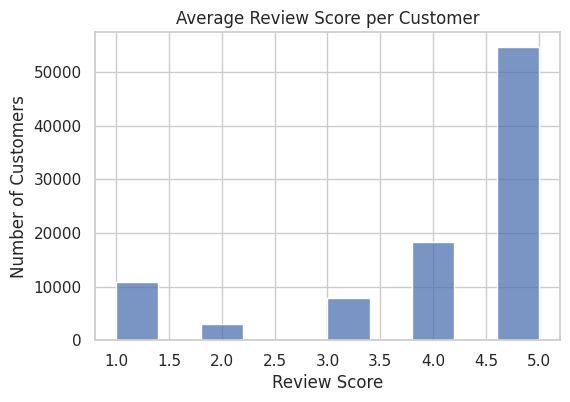

In [34]:
plt.figure(figsize=(6, 4))
sns.histplot(customer_group['avg_review_score'].dropna(), bins=10)
plt.title('Average Review Score per Customer')
plt.xlabel('Review Score')
plt.ylabel('Number of Customers')
plt.show()


In [35]:
# Select relevant features
features = customer_group[[
    "recency_days", "order_count", "total_payment", "unique_categories", "avg_review_score"
]].dropna().copy()

features["total_payment_log"] = np.log1p(features["total_payment"])
features["order_count_log"] = np.log1p(features["order_count"])

features.drop(columns=["total_payment", "order_count"], inplace=True)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
features_scaled_df.head()


recency_days  unique_categories  avg_review_score  total_payment_log  \
0     -0.831428          -0.018573          0.682036           0.160598   
1     -0.811874          -0.018573         -0.063111          -1.622633   
2      1.938720          -0.018573         -0.808258          -0.381795   
3      0.530833          -0.018573         -0.063111          -1.118137   
4      0.315739          -0.018573          0.682036           0.518267   

   order_count_log  
0         -0.17398  
1         -0.17398  
2         -0.17398  
3         -0.17398  
4         -0.17398

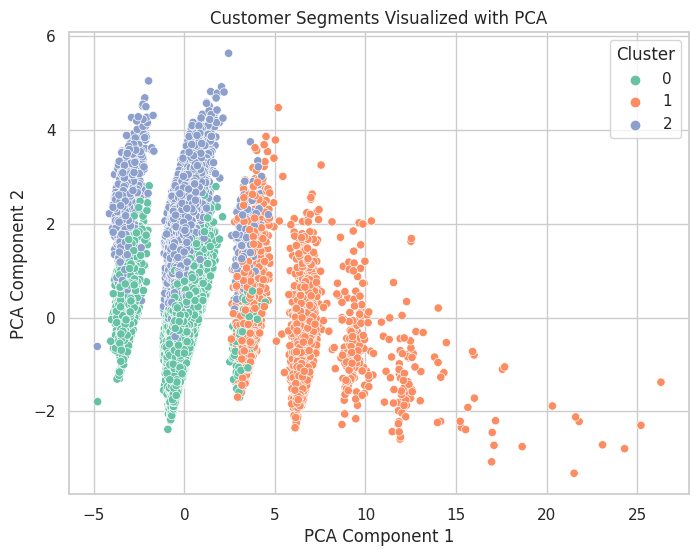

In [36]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

clusters = kmeans.fit_predict(features_scaled)

customer_segmented = customer_group.loc[features.index].copy()
customer_segmented["cluster"] = clusters

customer_segmented.groupby("cluster").agg({
    "recency_days": "mean",
    "order_count": "mean",
    "total_payment": "mean",
    "unique_categories": "mean",
    "avg_review_score": "mean",
    "customer_unique_id": "count"
}).rename(columns={"customer_unique_id": "n_customers"})

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=customer_segmented["cluster"], palette='Set2')
plt.title("Customer Segments Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()



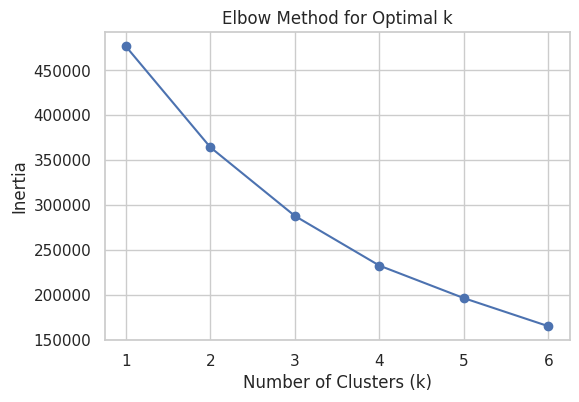

In [37]:

inertia = []
K = range(1, 7)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)  # <- set n_init explicitly
    km.fit(features_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()


In [40]:
customer_segmented.groupby("cluster").agg({
    "recency_days": "mean",
    "order_count": "mean",
    "total_payment": "mean",
    "unique_categories": "mean",
    "avg_review_score": "mean",
    "customer_unique_id": "count"
}).rename(columns={"customer_unique_id": "n_customers"})


recency_days  order_count  total_payment  unique_categories  \
cluster                                                                
0          235.957498     1.000000     528.687878           1.017101   
1          466.434832     1.000000     119.908987           1.001711   
2          248.020820     2.156467     433.193552           2.094637   
3          353.885641     1.000000     182.074123           0.000000   
4          182.557301     1.000000      81.075167           1.000207   
5          289.485149     2.062942     552.366393           0.990806   
6          288.530074     1.000000     237.522511           1.018681   

         avg_review_score  n_customers  
cluster                                 
0                4.593499        17952  
1                4.586042        24552  
2                4.198760         1585  
3                3.178462         1950  
4                4.620343        33795  
5                3.983226         1414  
6                1.408824        14132

In [41]:
customer_group

customer_unique_id       customer_city customer_state  \
0      0000366f3b9a7992bf8c76cfdf3221e2             cajamar             SP   
1      0000b849f77a49e4a4ce2b2a4ca5be3f              osasco             SP   
2      0000f46a3911fa3c0805444483337064            sao jose             SC   
3      0000f6ccb0745a6a4b88665a16c9f078               belem             PA   
4      0004aac84e0df4da2b147fca70cf8255            sorocaba             SP   
...                                 ...                 ...            ...   
96091  fffcf5a5ff07b0908bd4e2dbc735a684             sanharo             PE   
96092  fffea47cd6d3cc0a88bd621562a9d061    feira de santana             BA   
96093  ffff371b4d645b6ecea244b27531430a               sinop             MT   
96094  ffff5962728ec6157033ef9805bacc48  bom jesus do norte             ES   
96095  ffffd2657e2aad2907e67c3e9daecbeb         campo largo             PR   

      order_purchase_timestamp  recency_days  order_count  total_payment  \
0          2018-05-10 10:56:27           160            1         141.90   
1          2018-05-07 11:11:27           163            1          27.19   
2          2017-03-10 21:05:03           585            1          86.22   
3          2017-10-12 20:29:41           369            1          43.62   
4          2017-11-14 19:45:42           336            1         196.89   
...                        ...           ...          ...            ...   
96091      2017-06-08 21:00:36           495            1        4134.84   
96092      2017-12-10 20:07:56           310            1          84.58   
96093      2017-02-07 15:49:16           617            1         112.46   
96094      2018-05-02 15:17:41           168            1         133.69   
96095      2017-05-02 20:18:45           532            1          71.56   

       unique_categories  avg_review_score  log_total_payment  
0                      1               5.0           4.962145  
1                      1               4.0           3.338967  
2                      1               3.0           4.468434  
3                      1               4.0           3.798182  
4                      1               5.0           5.287711  
...                  ...               ...                ...  
96091                  1               5.0           8.327446  
96092                  1               4.0           4.449452  
96093                  1               5.0           4.731450  
96094                  1               5.0           4.902976  
96095                  1               5.0           4.284414  

[95380 rows x 10 columns]

In [42]:
# from matplotlib import pyplot as plt
# customer_segmented['recency_days'].plot(kind='line', figsize=(8, 4), title='recency_days')
# plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


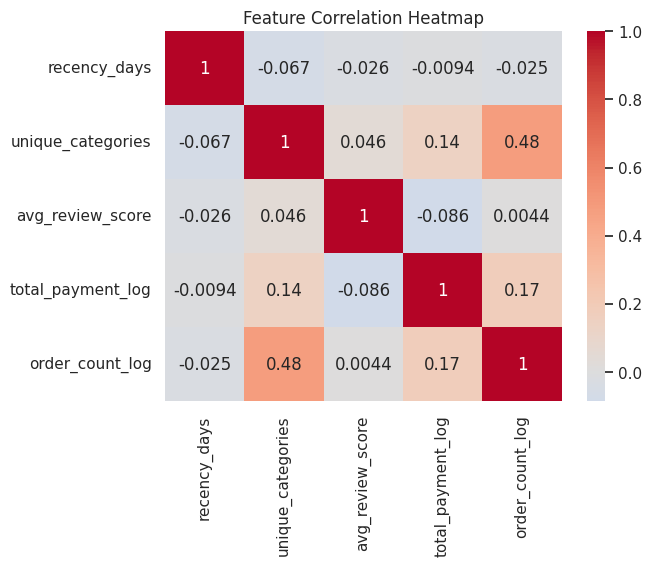

In [43]:
sns.heatmap(features.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

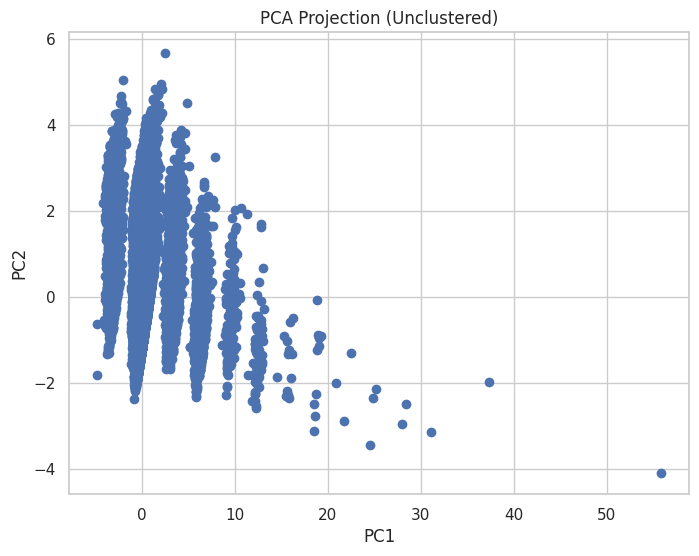

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.3436536508784834, 1.2027782408852687)

In [44]:
features = ['recency_days', 'order_count', 'log_total_payment', 'unique_categories', 'avg_review_score']
X = customer_group[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA Projection (Unclustered)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)


sil_score = silhouette_score(X_scaled, labels)
db_score = davies_bouldin_score(X_scaled, labels)


sil_score, db_score

In [45]:
# (higher is better, range -1 to 1)
silhouette = silhouette_score(features_scaled, customer_segmented["cluster"])
print("Silhouette Score:", round(silhouette, 3))

# (lower is better)
db_score = davies_bouldin_score(features_scaled, customer_segmented["cluster"])
print("Davies–Bouldin Score:", round(db_score, 3))


Silhouette Score: 0.323
Davies–Bouldin Score: 0.905


In [46]:
sample_size = 6000  # or even 1000 if needed
sample_indices = np.random.choice(len(features_scaled), sample_size, replace=False)
features_sampled = features_scaled[sample_indices]
clusters_sampled = customer_segmented["cluster"].iloc[sample_indices]


In [66]:
def plot_clusters(labels, title, alpha=0.6):

    plt.figure(figsize=(9, 7))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10', alpha=alpha)
    plt.title(title)
    plt.show()

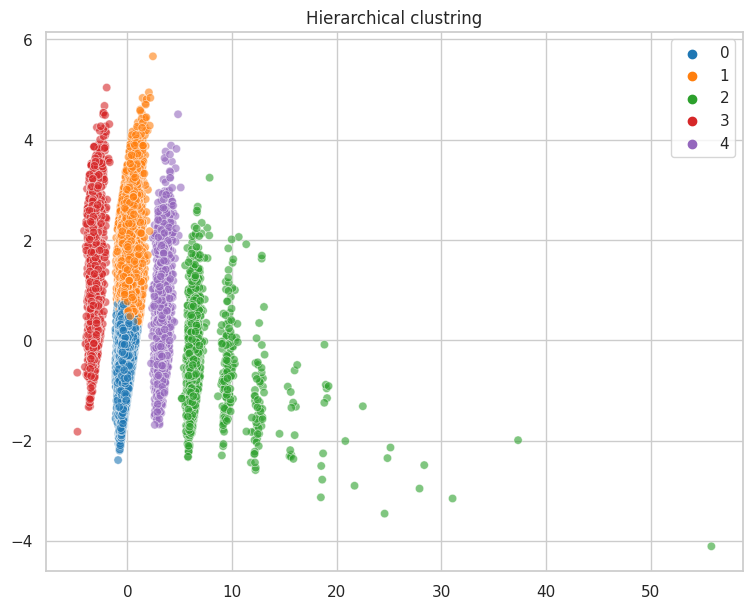

In [67]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Compute k-NN graph (sparse matrix, reduces memory)
connectivity = kneighbors_graph(
    X_pca,
    n_neighbors=10,
    mode='connectivity',
    include_self=False
)

# Hierarchical clustering with connectivity
model = AgglomerativeClustering(
    n_clusters=5,
    metric='euclidean',
    linkage='ward',
    connectivity=connectivity,
    memory='./cache'
)
labels = model.fit_predict(X_pca)
plot_clusters(labels,'Hierarchical clustring')

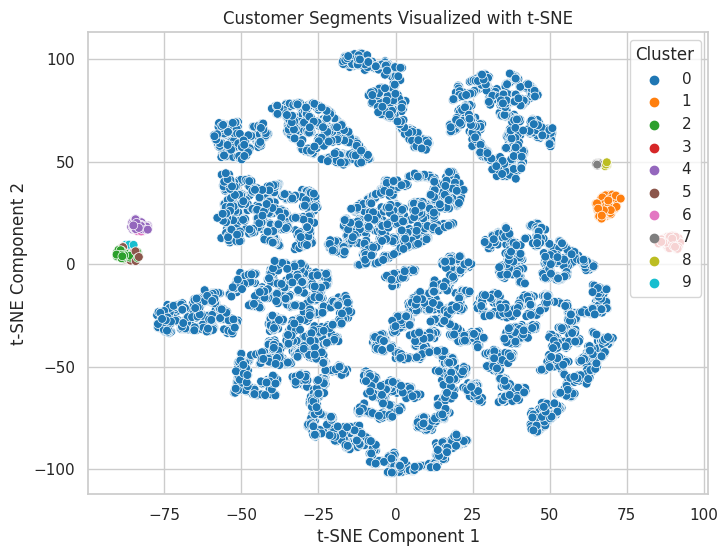

In [74]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, method='barnes_hut')

tsne_results = tsne.fit_transform(features_sampled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],
                hue=clusters_sampled, palette='tab10', s=40)
plt.title("Customer Segments Visualized with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.show()

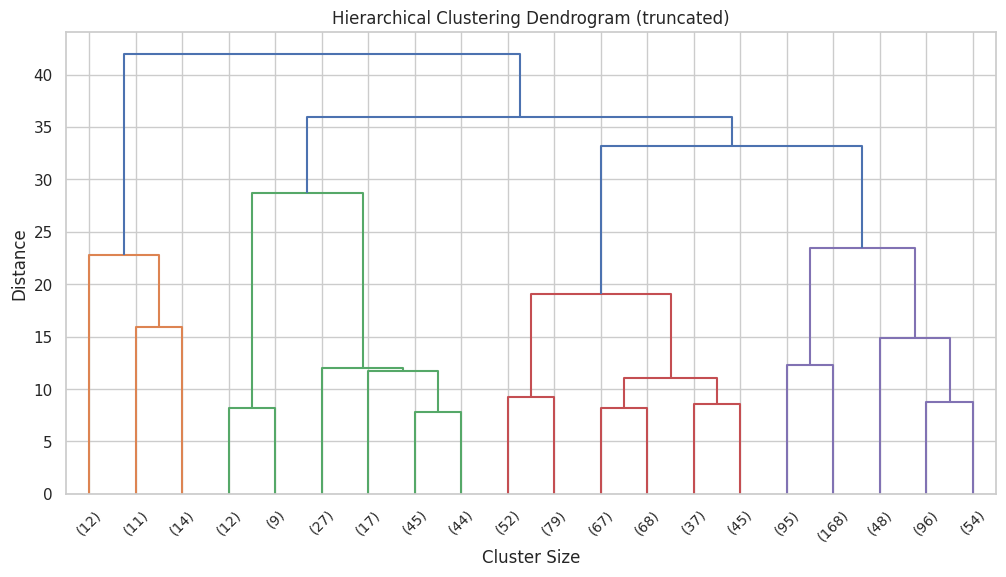

In [70]:
# avoid overplotting
subset = features_scaled[:1000]

linked = linkage(subset, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=45., leaf_font_size=10.)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


In [71]:
n_clusters = 4

hier_clusters = fcluster(linked, t=n_clusters, criterion='maxclust')

subset_customers = customer_group.iloc[:1000].copy()
subset_customers["hier_cluster"] = hier_clusters


In [72]:
sil_score = silhouette_score(subset, hier_clusters)
db_score = davies_bouldin_score(subset, hier_clusters)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies–Bouldin Score: {db_score:.3f}")


Silhouette Score: 0.268
Davies–Bouldin Score: 1.229


In [51]:
print(customer_group.columns.tolist())

['customer_unique_id', 'customer_city', 'customer_state', 'order_purchase_timestamp', 'recency_days', 'order_count', 'total_payment', 'unique_categories', 'avg_review_score', 'log_total_payment']


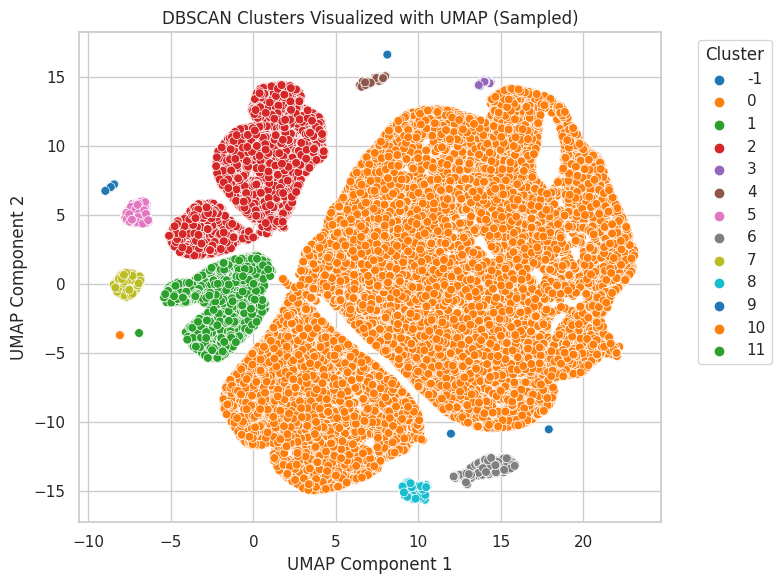

DBSCAN noise points: 36


In [99]:
# sample_size = 10000
# sample_indices = np.random.choice(len(features_scaled), sample_size, replace=False)
# features_sampled = features_scaled[sample_indices]

umap = UMAP(n_components=2)
umap_results = umap.fit_transform(features_scaled)

db = DBSCAN(eps=0.6, min_samples=25, algorithm='kd_tree')
db_clusters = db.fit_predict(umap_results)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1],
                hue=db_clusters, palette='tab10', s=40)
plt.title("DBSCAN Clusters Visualized with UMAP (Sampled)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


print("DBSCAN noise points:", sum(db_clusters == -1))


In [52]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=10, random_state=42)
# features_reduced = pca.fit_transform(features_scaled)

Text(0.5, 1.0, 'k-distance Graph')

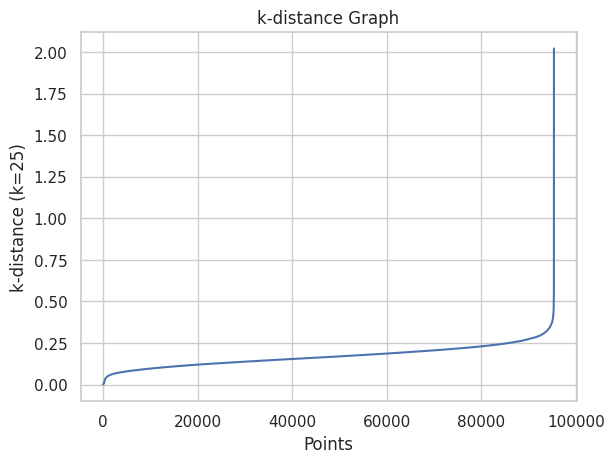

In [73]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=25)
neighbors_fit = neighbors.fit(umap_results)
distances, indices = neighbors_fit.kneighbors(umap_results)

k_distances = np.sort(distances[:, -1])
plt.plot(k_distances)
plt.xlabel('Points')
plt.ylabel('k-distance (k=25)')
plt.title('k-distance Graph')


In [75]:
db_dense = DBSCAN(eps=0.3, min_samples=25).fit(umap_results)
labels_dense = db_dense.labels_

mask_noise = labels_dense == -1
remaining_points = umap_results[mask_noise]
db_sparse = DBSCAN(eps=0.8, min_samples=10).fit(remaining_points)


In [76]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=5)
cluster_labels = clusterer.fit_predict(umap_results)

In [79]:
db_original = DBSCAN(eps=0.5, min_samples=25).fit(features_scaled)

from sklearn.decomposition import PCA
pca = PCA(n_components=5) 
pca_results = pca.fit_transform(features_scaled)
db_pca = DBSCAN(eps=0.6, min_samples=25).fit(pca_results)


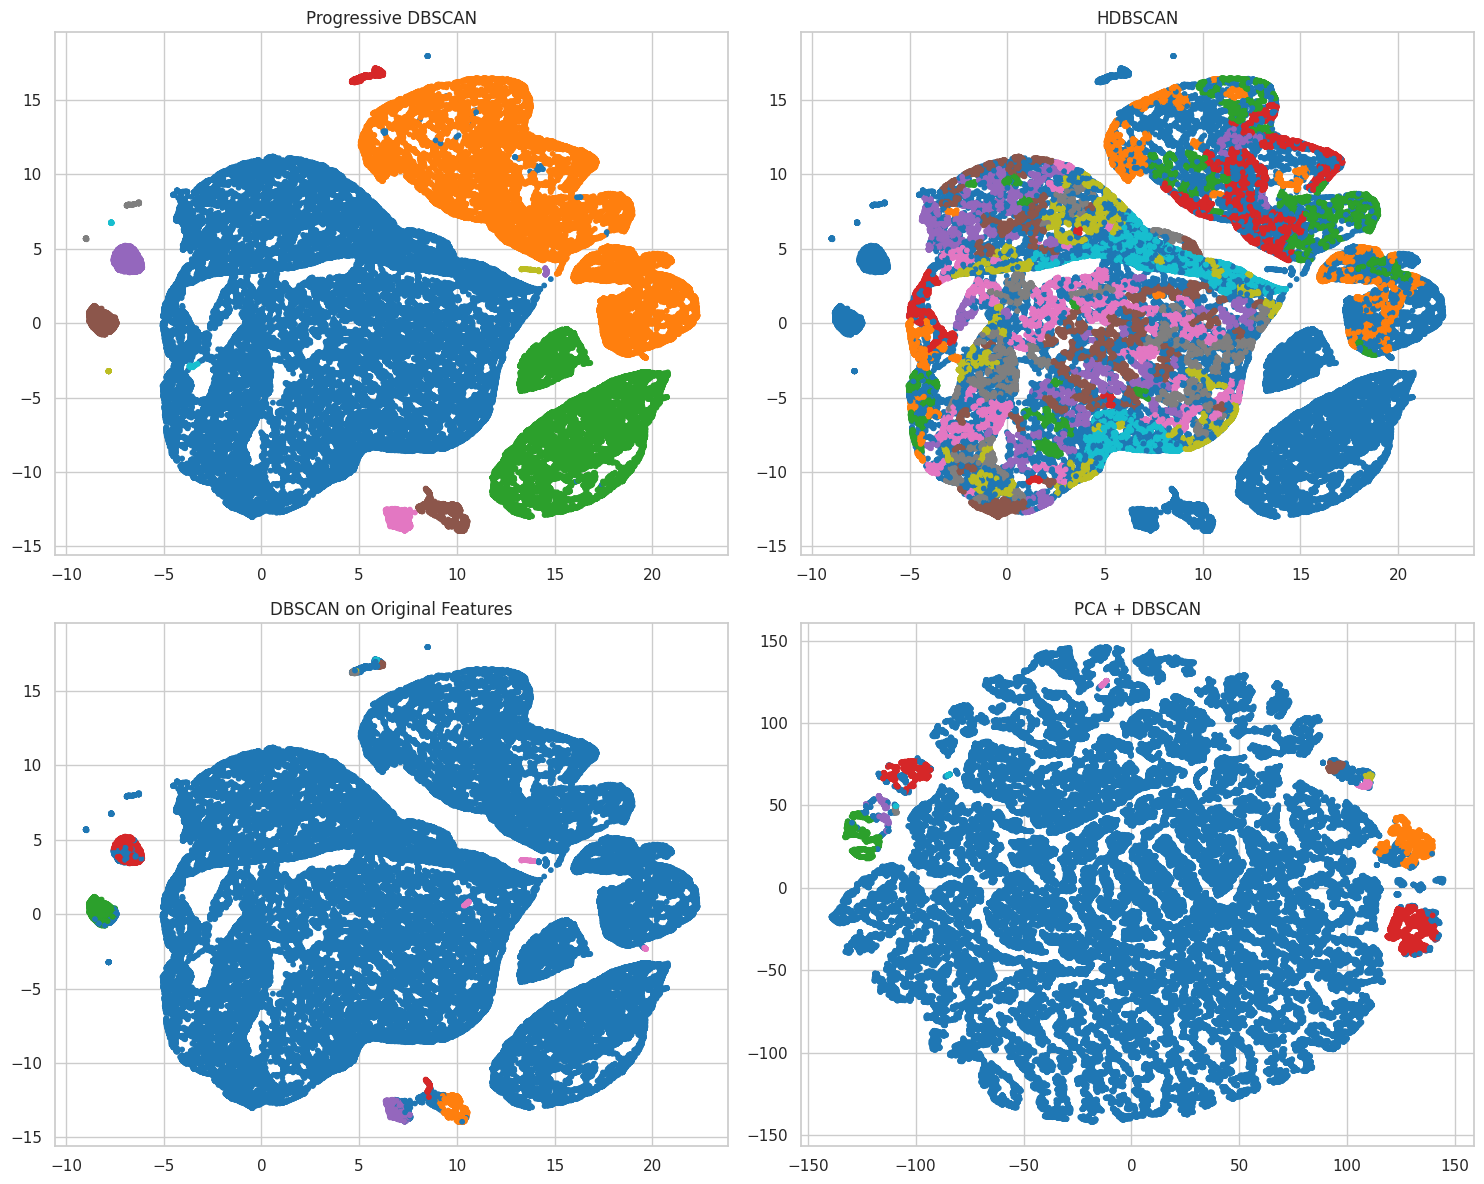

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# DBSCAN Progressive
axes[0].scatter(umap_results[:, 0], umap_results[:, 1], c=labels_dense, cmap='tab10', s=10)
axes[0].set_title("Progressive DBSCAN")

# HDBSCAN
axes[1].scatter(umap_results[:, 0], umap_results[:, 1], c=cluster_labels, cmap='tab10', s=10)
axes[1].set_title("HDBSCAN")

# Original DBSCAN
axes[2].scatter(umap_results[:, 0], umap_results[:, 1], c=db_original.labels_, cmap='tab10', s=10)
axes[2].set_title("DBSCAN on Original Features")

# PCA + DBSCAN
tsne_pca = TSNE(n_components=2).fit_transform(pca_results)
axes[3].scatter(tsne_pca[:, 0], tsne_pca[:, 1], c=db_pca.labels_, cmap='tab10', s=10)
axes[3].set_title("PCA + DBSCAN")

plt.tight_layout()
plt.show()


In [81]:
from sklearn import metrics

clustering_results = {
    "Progressive DBSCAN": labels_dense,
    "HDBSCAN": cluster_labels,
    "Original DBSCAN": db_original.labels_,
    "PCA + DBSCAN": db_pca.labels_
}

for name, labels in clustering_results.items():
    if len(set(labels)) > 1: 
        mask = labels != -1
        if sum(mask) > 1:
            score = metrics.silhouette_score(features_scaled[mask], labels[mask])
            print(f"{name} Silhouette Score: {score:.4f}")
    
    n_clusters = len(set([x for x in labels if x >= 0]))
    noise_percent = 100 * (labels == -1).sum() / len(labels)
    print(f"{name}: {n_clusters} clusters, {noise_percent:.1f}% noise")
    print("-" * 40)


Progressive DBSCAN Silhouette Score: -0.2356
Progressive DBSCAN: 17 clusters, 0.2% noise
----------------------------------------
HDBSCAN Silhouette Score: 0.0340
HDBSCAN: 1041 clusters, 18.0% noise
----------------------------------------
Original DBSCAN Silhouette Score: 0.2856
Original DBSCAN: 13 clusters, 2.4% noise
----------------------------------------
PCA + DBSCAN Silhouette Score: 0.2782
PCA + DBSCAN: 13 clusters, 1.6% noise
----------------------------------------


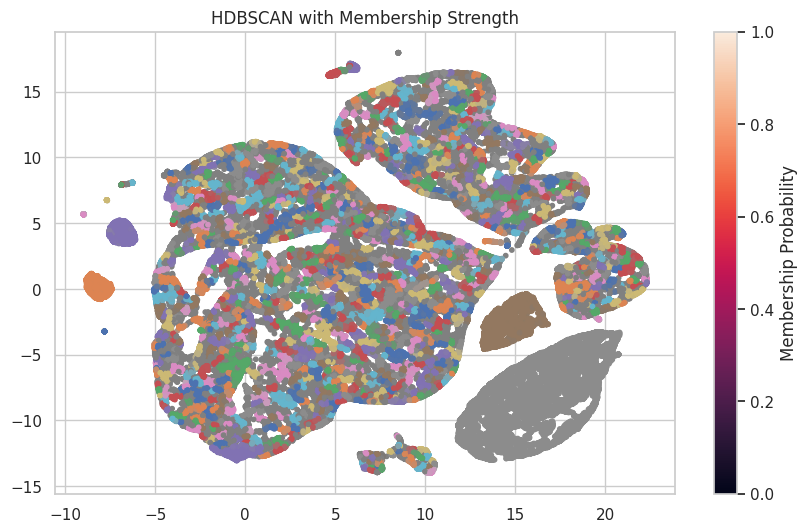

In [82]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette()
cluster_colors = [
    sns.desaturate(palette[col % 10], sat) if col >= 0 else (0.5, 0.5, 0.5) 
    for col, sat in zip(clusterer.labels_, clusterer.probabilities_)
]
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=cluster_colors, s=10)
plt.title("HDBSCAN with Membership Strength")
plt.colorbar(label="Membership Probability")
plt.show()


In [86]:
best_labels = cluster_labels

cluster_df = pd.DataFrame(features_scaled, columns=[f'feature_{i}' for i in range(features_scaled.shape[1])])
cluster_df['cluster'] = best_labels

for cluster_id in sorted(set(best_labels)):
    if cluster_id == -1:
        print("Noise points statistics:")
    else:
        print(f"Cluster {cluster_id} statistics:")
    
    cluster_data = cluster_df[cluster_df['cluster'] == cluster_id]
    print(f"Size: {len(cluster_data)} points ({100*len(cluster_data)/len(cluster_df):.1f}%)")
    print(cluster_data.describe().T)
    print("-" * 40)

Noise points statistics:
Size: 17170 points (18.0%)
             count      mean       std       min       25%       50%  \
feature_0  17170.0  0.028935  0.999136 -1.587516 -0.818392 -0.075341   
feature_1  17170.0 -0.087794  0.699174 -4.537675 -0.018573 -0.018573   
feature_2  17170.0  0.326558  0.559607 -2.298553 -0.063111  0.682036   
feature_3  17170.0 -0.063753  0.967288 -5.290839 -0.799752 -0.128417   
feature_4  17170.0 -0.161321  0.445154 -0.173980 -0.173980 -0.173980   
cluster    17170.0 -1.000000  0.000000 -1.000000 -1.000000 -1.000000   

                75%        max  
feature_0  0.765480   2.355871  
feature_1 -0.018573   9.019631  
feature_2  0.682036   0.682036  
feature_3  0.502091   5.365427  
feature_4 -0.173980  27.833891  
cluster   -1.000000  -1.000000  
----------------------------------------
Cluster 0 statistics:
Size: 38 points (0.0%)
           count      mean           std       min       25%       50%  \
feature_0   38.0 -0.330229  7.992308e-01 -1.515818 -

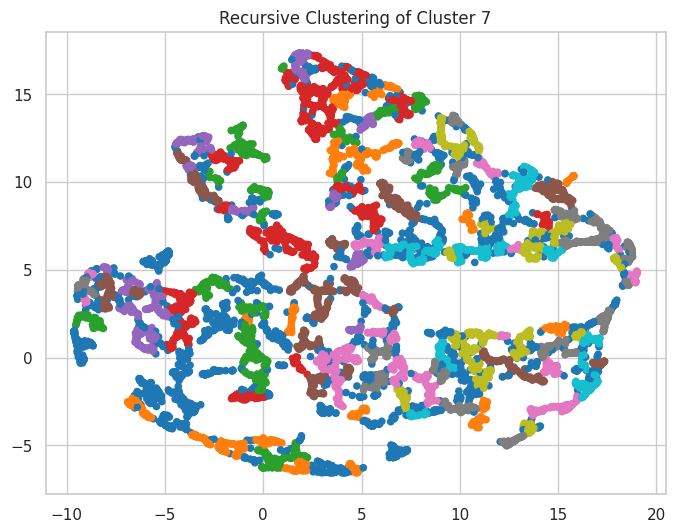

In [87]:
from collections import Counter
cluster_counts = Counter(best_labels[best_labels >= 0])
target_cluster = cluster_counts.most_common(1)[0][0]

cluster_mask = best_labels == target_cluster
subcluster_data = features_scaled[cluster_mask]


sub_umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1).fit_transform(subcluster_data)
sub_clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=3).fit(sub_umap)

plt.figure(figsize=(8, 6))
plt.scatter(sub_umap[:, 0], sub_umap[:, 1], c=sub_clusterer.labels_, cmap='tab10', s=20)
plt.title(f"Recursive Clustering of Cluster {target_cluster}")
plt.show()


In [89]:
# seeds = [42, 123, 999]
# umap_results_list = []
# hdbscan_labels_list = []

# for seed in seeds:
#     umap_model = UMAP(n_components=2, random_state=seed).fit_transform(features_scaled)
#     umap_results_list.append(umap_model)
    
#     clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=5).fit(umap_model)
#     hdbscan_labels_list.append(clusterer.labels_)


# fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# for i, (embedding, labels) in enumerate(zip(umap_results_list, hdbscan_labels_list)):
#     axes[i].scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=10)
#     axes[i].set_title(f"Seed {seeds[i]}: {len(set(labels))-1} clusters")
# plt.tight_layout()
# plt.show()


In [98]:
# # sample_size = 10000
# # sample_indices = np.random.choice(len(features_scaled), sample_size, replace=False)
# # features_sampled = features_scaled[sample_indices]

# umap = UMAP(n_components=2)
# umap_results = umap.fit_transform(features_scaled)

# db = DBSCAN(eps=0.6, min_samples=25, algorithm='kd_tree')
# db_clusters = db.fit_predict(umap_results)

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1],
#                 hue=db_clusters, palette='tab10', s=40)
# plt.title("DBSCAN Clusters Visualized with UMAP (Sampled)")
# plt.xlabel("UMAP Component 1")
# plt.ylabel("UMAP Component 2")
# plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1.05, 1))
# plt.tight_layout()
# plt.show()


# print("DBSCAN noise points:", sum(db_clusters == -1))


In [91]:

sample_size = 5000
sample_indices = np.random.choice(len(features_scaled), sample_size, replace=False)
features_sampled = features_scaled[sample_indices]

db = DBSCAN(eps=0.7, min_samples=25, algorithm='kd_tree')


db_clusters = db.fit_predict(features_scaled)
customer_segmented["dbscan_cluster"] = db_clusters
print("DBSCAN noise points:", sum(db_clusters == -1))



DBSCAN noise points: 1126


In [92]:
# non_noise_mask = db_clusters != -1
# features_non_noise = features_scaled[non_noise_mask]
# clusters_non_noise = db_clusters[non_noise_mask]

# sample_size = 10000
# if len(features_non_noise) > sample_size:
#     sample_indices = np.random.choice(len(features_non_noise), sample_size, replace=False)
#     features_sampled = features_non_noise[sample_indices]
#     clusters_sampled = clusters_non_noise[sample_indices]
# else:
#     features_sampled = features_non_noise
#     clusters_sampled = clusters_non_noise

# umap = UMAP(n_components=2)
# umap_results = umap.fit_transform(features_sampled)


# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1],
#                 hue=clusters_sampled, palette='tab10', s=40)
# plt.title("DBSCAN Clusters Visualized with UMAP (Sampled, No Noise)")
# plt.xlabel("UMAP Component 1")
# plt.ylabel("UMAP Component 2")
# plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1.05, 1))
# plt.tight_layout()
# plt.show()


In [93]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(features)

# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10', alpha=0.6)
# plt.title("Clusters by Bisecting KMeans (t-SNE projection)")
# plt.xlabel("t-SNE 1")
# plt.ylabel("t-SNE 2")
# plt.legend(*scatter.legend_elements(), title="Cluster")
# plt.grid(True)
# plt.show()


In [95]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


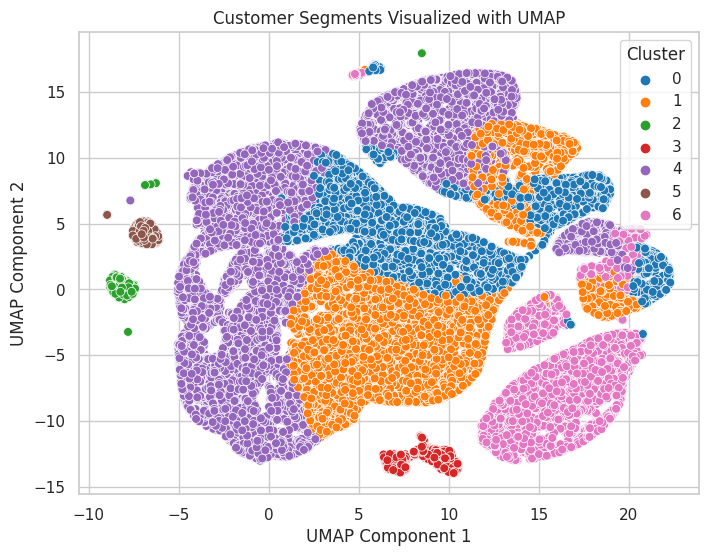

In [58]:


umap = UMAP(n_components=2)
umap_results = umap.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1],
                hue=customer_segmented["cluster"], palette='tab10', s=40)
plt.title("Customer Segments Visualized with UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="Cluster")
plt.show()


In [59]:
cluster_profiles = customer_segmented.groupby('cluster').agg({
    'recency_days': 'mean',
    'order_count': 'mean',
    'total_payment': 'mean',
    'unique_categories': 'mean',
    'avg_review_score': 'mean'
}).round(2).reset_index()

cluster_profiles


cluster  recency_days  order_count  total_payment  unique_categories  \
0        0        235.96         1.00         528.69               1.02   
1        1        466.43         1.00         119.91               1.00   
2        2        248.02         2.16         433.19               2.09   
3        3        353.89         1.00         182.07               0.00   
4        4        182.56         1.00          81.08               1.00   
5        5        289.49         2.06         552.37               0.99   
6        6        288.53         1.00         237.52               1.02   

   avg_review_score  
0              4.59  
1              4.59  
2              4.20  
3              3.18  
4              4.62  
5              3.98  
6              1.41

In [60]:

def get_sentiment(text):
    if pd.isnull(text): return 0.0
    return TextBlob(text).sentiment.polarity

orders_full_reviews['review_sentiment'] = (
    orders_full_reviews['review_comment_message']
    .apply(get_sentiment)
)

sentiment_by_customer = (
    orders_full_reviews
    .groupby('customer_unique_id')['review_sentiment']
    .mean()
    .reset_index()
    .rename(columns={'review_sentiment': 'avg_review_sentiment'})
)

orders_full_reviews['order_purchase_timestamp'] = pd.to_datetime(
    orders_full_reviews['order_purchase_timestamp']
)
first_purchase = (
    orders_full_reviews
    .groupby('customer_unique_id')['order_purchase_timestamp']
    .min()
    .reset_index()
    .rename(columns={'order_purchase_timestamp': 'first_purchase_date'})
)

customer_group = (
    customer_group
    .merge(sentiment_by_customer, on='customer_unique_id', how='left')
    .merge(first_purchase, on='customer_unique_id', how='left')
)

ref_date = orders_full_reviews['order_purchase_timestamp'].max()
customer_group['account_age_days'] = (
    ref_date - customer_group['first_purchase_date']
).dt.days

customer_group['spending_velocity'] = (
    customer_group['total_payment'] / (customer_group['account_age_days'] + 1)
)

customer_group.head()


customer_unique_id customer_city customer_state  \
0  0000366f3b9a7992bf8c76cfdf3221e2       cajamar             SP   
1  0000b849f77a49e4a4ce2b2a4ca5be3f        osasco             SP   
2  0000f46a3911fa3c0805444483337064      sao jose             SC   
3  0000f6ccb0745a6a4b88665a16c9f078         belem             PA   
4  0004aac84e0df4da2b147fca70cf8255      sorocaba             SP   

  order_purchase_timestamp  recency_days  order_count  total_payment  \
0      2018-05-10 10:56:27           160            1         141.90   
1      2018-05-07 11:11:27           163            1          27.19   
2      2017-03-10 21:05:03           585            1          86.22   
3      2017-10-12 20:29:41           369            1          43.62   
4      2017-11-14 19:45:42           336            1         196.89   

   unique_categories  avg_review_score  log_total_payment  \
0                  1               5.0           4.962145   
1                  1               4.0           3.338967   
2                  1               3.0           4.468434   
3                  1               4.0           3.798182   
4                  1               5.0           5.287711   

   avg_review_sentiment first_purchase_date  account_age_days  \
0              0.333333 2018-05-10 10:56:27               160   
1              0.000000 2018-05-07 11:11:27               163   
2              0.000000 2017-03-10 21:05:03               585   
3              0.000000 2017-10-12 20:29:41               369   
4              0.000000 2017-11-14 19:45:42               336   

   spending_velocity  
0           0.881366  
1           0.165793  
2           0.147133  
3           0.117892  
4           0.584243

In [96]:

features = [
    'recency_days', 'order_count', 'log_total_payment',
    'unique_categories', 'avg_review_score',
    'avg_review_sentiment', 'spending_velocity'
]

X = customer_group[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


best_k = 5 
km = KMeans(n_clusters=best_k, random_state=42)
customer_group['cluster_enhanced'] = km.fit_predict(X_scaled)

sil_new = silhouette_score(X_scaled, customer_group['cluster_enhanced'])
print(f"Original Silhouette ≈ {sil_score:.3f}")
print(f"Enhanced Silhouette ≈ {sil_new:.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Original Silhouette ≈ 0.268
Enhanced Silhouette ≈ 0.284


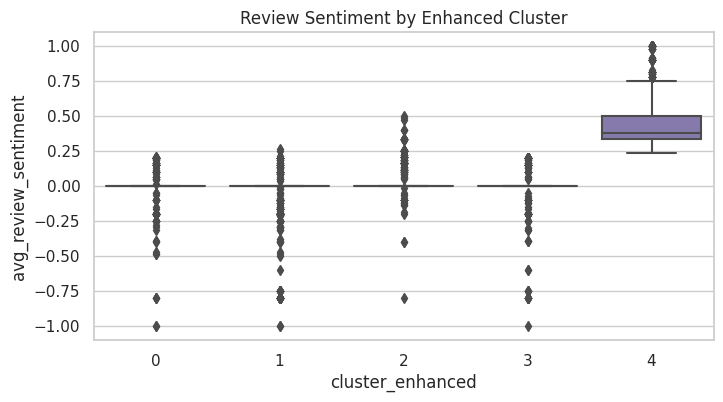

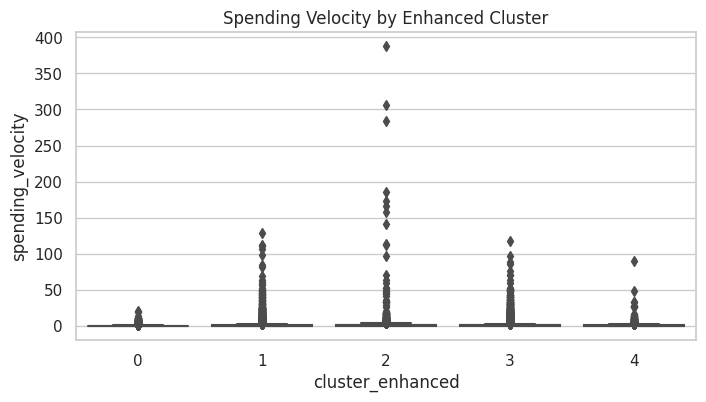

In [97]:
plt.figure(figsize=(8,4))
sns.boxplot(
    data=customer_group,
    x='cluster_enhanced', y='avg_review_sentiment'
)
plt.title("Review Sentiment by Enhanced Cluster")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(
    data=customer_group,
    x='cluster_enhanced', y='spending_velocity'
)
plt.title("Spending Velocity by Enhanced Cluster")
plt.show()


In [100]:
cluster_df = pd.DataFrame(features_scaled, columns=[f'feature_{i}' for i in range(features_scaled.shape[1])])
cluster_df['cluster'] = best_labels


In [104]:
cluster_df['customer_unique_id'] = customer_group.customer_unique_id 


In [106]:
marketing_df = pd.read_csv('/kaggle/input/marketing-funnel-olist/olist_marketing_qualified_leads_dataset.csv')

In [109]:
customer_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95380 entries, 0 to 95379
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        95380 non-null  object        
 1   customer_city             95380 non-null  object        
 2   customer_state            95380 non-null  object        
 3   order_purchase_timestamp  95380 non-null  datetime64[ns]
 4   recency_days              95380 non-null  int64         
 5   order_count               95380 non-null  int64         
 6   total_payment             95380 non-null  float64       
 7   unique_categories         95380 non-null  int64         
 8   avg_review_score          95380 non-null  float64       
 9   log_total_payment         95380 non-null  float64       
 10  avg_review_sentiment      95380 non-null  float64       
 11  first_purchase_date       95380 non-null  datetime64[ns]
 12  account_age_days  

In [133]:
train_data = customer_group[customer_group['order_purchase_timestamp'].dt.year == 2017]
test_data = customer_group[customer_group['order_purchase_timestamp'].dt.year == 2018]
features = customer_group.columns[1:-2]

In [134]:
train_data[features]

customer_city customer_state order_purchase_timestamp  recency_days  \
2              sao jose             SC      2017-03-10 21:05:03           585   
3                 belem             PA      2017-10-12 20:29:41           369   
4              sorocaba             SP      2017-11-14 19:45:42           336   
8           teresopolis             RJ      2017-03-04 23:32:12           591   
10        mimoso do sul             ES      2017-07-18 09:23:10           456   
...                 ...            ...                      ...           ...   
95373         fortaleza             CE      2017-12-27 22:36:41           293   
95375           sanharo             PE      2017-06-08 21:00:36           495   
95376  feira de santana             BA      2017-12-10 20:07:56           310   
95377             sinop             MT      2017-02-07 15:49:16           617   
95379       campo largo             PR      2017-05-02 20:18:45           532   

       order_count  total_payment  unique_categories  avg_review_score  \
2                1          86.22                  1               3.0   
3                1          43.62                  1               4.0   
4                1         196.89                  1               5.0   
8                1         150.12                  1               4.0   
10               1          29.00                  1               3.0   
...            ...            ...                ...               ...   
95373            1         167.32                  0               5.0   
95375            1        4134.84                  1               5.0   
95376            1          84.58                  1               4.0   
95377            1         112.46                  1               5.0   
95379            1          71.56                  1               5.0   

       log_total_payment  avg_review_sentiment first_purchase_date  \
2               4.468434                   0.0 2017-03-10 21:05:03   
3               3.798182                   0.0 2017-10-12 20:29:41   
4               5.287711                   0.0 2017-11-14 19:45:42   
8               5.018074                   0.0 2017-03-04 23:32:12   
10              3.401197                   0.0 2017-07-18 09:23:10   
...                  ...                   ...                 ...   
95373           5.125867                   0.0 2017-12-27 22:36:41   
95375           8.327446                   0.0 2017-06-08 21:00:36   
95376           4.449452                   0.0 2017-12-10 20:07:56   
95377           4.731450                   0.0 2017-02-07 15:49:16   
95379           4.284414                   0.0 2017-05-02 20:18:45   

       account_age_days  
2                   585  
3                   369  
4                   336  
8                   591  
10                  456  
...                 ...  
95373               293  
95375               495  
95376               310  
95377               617  
95379               532  

[42669 rows x 12 columns]

In [136]:
train_data = train_data.copy()
test_data = test_data.copy()

for col in ['order_purchase_timestamp', 'first_purchase_date']:
    train_data.loc[:, col] = pd.to_datetime(train_data[col])
    train_data.loc[:, col + '_year'] = train_data[col].dt.year
    train_data.loc[:, col + '_month'] = train_data[col].dt.month
    train_data.loc[:, col + '_day'] = train_data[col].dt.day
    train_data.loc[:, col + '_weekday'] = train_data[col].dt.weekday
    train_data.loc[:, col + '_timestamp'] = train_data[col].astype(np.int64)

    test_data.loc[:, col] = pd.to_datetime(test_data[col])
    test_data.loc[:, col + '_year'] = test_data[col].dt.year
    test_data.loc[:, col + '_month'] = test_data[col].dt.month
    test_data.loc[:, col + '_day'] = test_data[col].dt.day
    test_data.loc[:, col + '_weekday'] = test_data[col].dt.weekday
    test_data.loc[:, col + '_timestamp'] = test_data[col].astype(np.int64)
